In [1]:
# Import libraries
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
# File path 
FILE = "./DaSilvaUrrutia/n200w100.001.txt"

In [3]:
# Default params
SUPPORTED_FORMAT = ['NUM', 'X', 'Y', 'DEMAND', 'READYTIME', 'DUEDATE', 'SERVICE']
MINUTES = 60
HOURS = 3600

DEFAULT_COLUMNS = ["SERVICE", "DEMAND"]
SERVICE = 30*MINUTES
DEMAND = 1

AGENTS = 17

OFFSET_TIMES = 8*HOURS
TIMES_COLUMNS = ["READYTIME","DUEDATE"]

LUNCH_BREAK_RANGE = (12*HOURS, 13.5*HOURS)
LUNCH_BREAK_TIME = 30*MINUTES

OFFICE_TIME = 1*HOURS
OFFICE_NUM = 0
OFFICE_X = .0
OFFICE_Y = .0

WORKING_TIME_RANGE = (OFFSET_TIMES, OFFSET_TIMES + 8*HOURS)

In [4]:
def read_input_tsptw(filename):
    """This function is used to convert input file to usable data"""
    nb_nodes = 0
    
    data_dict = dict()
    
    nodes_x = list()
    nodes_y = list()
       
    # Open file and read lines 
    with open(filename, "r") as file:
        # Initialize columns in empty dict
        columns = file.readline().replace("#","").split()
        if columns != SUPPORTED_FORMAT:
            print("ERROR! Format not supported.")
            return 
        
        # Add office to data
        data_dict.update({OFFICE_NUM: {'X': OFFICE_X, 'Y': OFFICE_Y}})
        
        # Add office to nodes
        nodes_x.append(OFFICE_X)
        nodes_y.append(OFFICE_Y)
            
        # For each data line
        for line in file.readlines():
            node_dict = dict()
            for k, val in zip(columns, line.split()):
                # Set default value for if column value is 0
                if not float(val) and k in DEFAULT_COLUMNS:
                    val = eval(k)
                # Offset times
                if k in TIMES_COLUMNS:
                    val = float(val)+OFFSET_TIMES
                node_dict.update({k: float(val)})
            # Get id
            node_id = node_dict.pop('NUM')
            # Insert new node in data dict
            data_dict.update({int(node_id): node_dict})            
            # Get nodes positions
            nodes_x.append(float(line.split()[columns.index('X')]))
            nodes_y.append(float(line.split()[columns.index('Y')]))

    # Get distance matrix
    distance_matrix = compute_distance_matrix(nodes_x, nodes_y)
    
    return (data_dict, distance_matrix, dict(enumerate(zip(nodes_x, nodes_y))))


def compute_distance_matrix(nodes_x, nodes_y):
    """This function is used to compute the distance matrix"""
    nb_customers = len(nodes_x)
    distance_matrix = [[None for i in range(nb_customers)] for j in range(nb_customers)]
    for i in range(nb_customers):
        distance_matrix[i][i] = 0
        for j in range(nb_customers):
            dist = compute_dist(nodes_x[i], nodes_x[j], nodes_y[i], nodes_y[j])
            distance_matrix[i][j] = dist
            distance_matrix[j][i] = dist
    return distance_matrix


def compute_dist(xi, xj, yi, yj):
    """This function is used to compute euclidean distance"""
    exact_dist = math.sqrt(math.pow(xi - xj, 2) + math.pow(yi - yj, 2))
    return int(math.floor(exact_dist + 0.5))

In [5]:
# Getting parameters
data_dict, distance_matrix, positions = read_input_tsptw(FILE)

In [6]:
data_dict

{0: {'X': 0.0, 'Y': 0.0},
 1: {'X': 34.0,
  'Y': 36.0,
  'DEMAND': 1.0,
  'READYTIME': 28800.0,
  'DUEDATE': 39201.0,
  'SERVICE': 1800.0},
 2: {'X': 22.0,
  'Y': 18.0,
  'DEMAND': 1.0,
  'READYTIME': 28806.0,
  'DUEDATE': 28835.0,
  'SERVICE': 1800.0},
 3: {'X': 32.0,
  'Y': 86.0,
  'DEMAND': 1.0,
  'READYTIME': 37846.0,
  'DUEDATE': 37896.0,
  'SERVICE': 1800.0},
 4: {'X': 26.0,
  'Y': 48.0,
  'DEMAND': 1.0,
  'READYTIME': 32802.0,
  'DUEDATE': 32846.0,
  'SERVICE': 1800.0},
 5: {'X': 99.0,
  'Y': 90.0,
  'DEMAND': 1.0,
  'READYTIME': 29272.0,
  'DUEDATE': 29310.0,
  'SERVICE': 1800.0},
 6: {'X': 74.0,
  'Y': 47.0,
  'DEMAND': 1.0,
  'READYTIME': 34989.0,
  'DUEDATE': 35056.0,
  'SERVICE': 1800.0},
 7: {'X': 90.0,
  'Y': 53.0,
  'DEMAND': 1.0,
  'READYTIME': 28900.0,
  'DUEDATE': 28950.0,
  'SERVICE': 1800.0},
 8: {'X': 10.0,
  'Y': 35.0,
  'DEMAND': 1.0,
  'READYTIME': 38877.0,
  'DUEDATE': 38885.0,
  'SERVICE': 1800.0},
 9: {'X': 24.0,
  'Y': 81.0,
  'DEMAND': 1.0,
  'READYTIME': 2

### Define function to plot the graph

In [7]:
def plot_model(model, positions):
    """This function is used to plot graph"""
    # Create figure
    plt.figure(figsize=(16,9))
    G = nx.Graph()
    # Add nodes to graph
    G.add_nodes_from(positions.keys())
    
    # Set labels dict
    node_labels = dict()
    # Set nodes positions
    for n, p in positions.items():
        G.nodes[n]['pos'] = p
        node_labels[n] = n

    # Define edges colors
    edge_colors = [plt.cm.tab20.colors[i] for i in model.keys()]
    # Add edges
    for t, l in model.items():
        for i in range(1,len(l['trip'])):
            G.add_edge(l['trip'][i-1], l['trip'][i], 
                       color=edge_colors[t], 
                       alpha=0.5, 
                       weight=4)
    # Set edges parameters 
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight'] for u,v in edges]
    alphas = [G[u][v]['alpha'] for u,v in edges]

    # Draw Nodes
    nx.draw_networkx_nodes(G, positions,
                           node_size=200,
                           node_color='c')
    # Draw Labels
    nx.draw_networkx_labels(G, positions, 
                            node_labels, 
                            font_size=10, 
                            font_color='k')
    # Draw Edges 
    nx.draw_networkx_edges(G, positions, 
                           alpha=0.5, 
                           width=weights, 
                           edge_color=colors)

    # Show graph
    plt.show()

In [8]:
# Prepare a dict for customers to serve
residual_customers = dict(zip(data_dict.keys(), [v['DEMAND'] if 'DEMAND' in v.keys() else 1 for v in data_dict.values()]))
residual_customers.pop(0)
# Prepare a dict for agent day
agent_serve_customer = dict()
for a in range(AGENTS):
    agent_serve_customer.update({
        a: {'actual_time': [WORKING_TIME_RANGE[0]+OFFICE_TIME,], 
            'trip': [0,],
            'lunch_done': False}
    })

In [9]:
def get_nearest(actual, in_set):
    """This function is used to get nearest neighbors with residual demand"""
    neighbors = list()
    # Get list of nearest neighbors sorted by their distance
    neighbors = list(sorted(dict(enumerate(distance_matrix[actual])).items(), key=lambda kv: kv[1]))

    # For each neighbor
    for n in neighbors:
        # If it's residual request is not zero
        if n[0] in in_set:
            return (n[0], n[1])
    return (None, None)

In [10]:
# While there are customers that need agent
while sum(residual_customers.values()):
    empty_round = True
    # For each agent serve nearest customer    
    for a in range(AGENTS):
        if agent_serve_customer[a]['actual_time'][-1] < WORKING_TIME_RANGE[1]:
            # Get nearest customer and it's distance
            nc, d = get_nearest(agent_serve_customer[a]['trip'][-1], [k for k, v in residual_customers.items() if v > 0])
            # If there are no more customers
            if not nc:
                empty_round = False
                break
            
            # If agent has enough goods to cover customer trip and serve
            if (WORKING_TIME_RANGE[1] - agent_serve_customer[a]['actual_time'][-1] >= 
                d + data_dict[nc]['SERVICE']):
      
                # Update trip and time
                agent_serve_customer[a]['trip'].append(nc)
                agent_serve_customer[a]['actual_time'].append(agent_serve_customer[a]['actual_time'][-1] + d +
                                                              data_dict[nc]['SERVICE'])
                # Remove customer from residual ones
                residual_customers[nc] = 0
                
                # A customer has been served
                empty_round = False
    
    # If round run empty there are customer to serve but not enough agents
    if empty_round:
        print("ERROR! There arent enough agents to serve all customers.")
        break
    # Check if agent need lunch break
    else:
        for a in range(AGENTS):
            # If is lunch time, agent have a lunch
            if (LUNCH_BREAK_RANGE[0] <= agent_serve_customer[a]['actual_time'][-1] <= LUNCH_BREAK_RANGE[1] and 
                not agent_serve_customer[a]['lunch_done']):
                agent_serve_customer[a]['lunch_done'] = True
                agent_serve_customer[a]['actual_time'].append(agent_serve_customer[a]['actual_time'][-1] + LUNCH_BREAK_TIME)

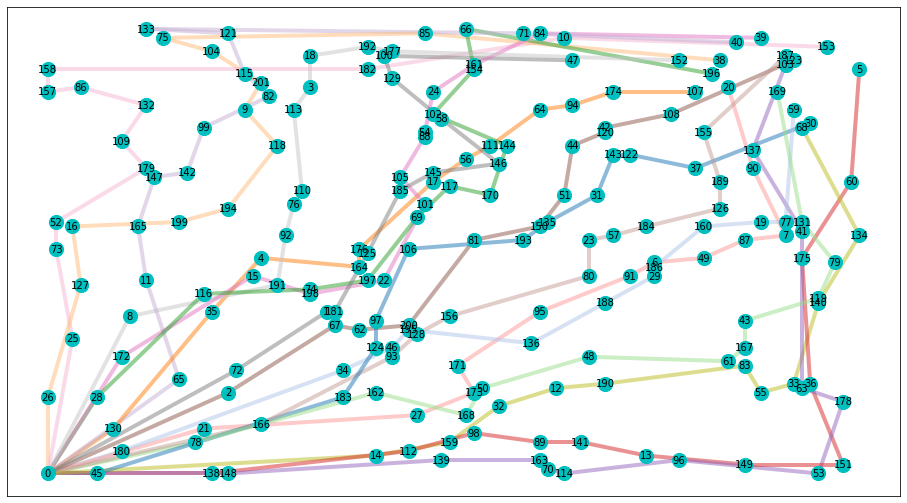

In [11]:
plot_model(agent_serve_customer, positions)